In [5]:
import torch
from torchvision.datasets import FashionMNIST
fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [6]:
train_input = fm_train.data
train_target = fm_train.targets

In [7]:
# 정규화 - 0~1
train_scaled = train_input / 255.0

In [8]:
# 훈련세트, 검증세트
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [10]:
# 모델을 위한 층 구성
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 10)
)

In [11]:
# GPU, CPU 결정, 모델에 연결
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [13]:
# 손실 함수, 옵티마이저
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# 훈련 하기 
train_hist = [] # 훈련세트 에포크 마다의 loss 값
val_hist = [] # 검증세트 에포크마다의 loss값
patience = 3 
best_loss = -1
early_stopping_counter = 0
epochs = 50 
batches = int(len(train_scaled) / 32) 
for epoch in range(epochs): # 50 에포크
    model.train() # 훈련 시작
    train_loss = 0 # 에포크당 훈련 세트 평균 로스
    for i in range(batches): # 미니배치 경사 하강법(32개씩, 1500회)
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)

        optimizer.zero_grad() # 그레디언트 연산 초기화
        outputs = model(inputs) # 예측값 추론 

        loss = criterion(outputs, targets) # 손실값(loss)
        loss.backward() # 역전파 
        optimizer.step() # 모델 파라미터 업데이트 

        train_loss += loss.item() # 미니 배치 마다의 손실값(loss)을 누적
    
    model.eval() # 평가 진행
    val_loss = 0
    with torch.no_grad(): # 평가를 하는 것이므로 그레이디언드 연산 X
        val_scaled = val_scaled.to(device)
        val_target = val_target.to(device)
        outputs = model(val_scaled) # 검증 세트의 예측값 
        loss = criterion(outputs, val_target) # 검증 세트의 손실값(loss)
        val_loss = loss.item()
    
    # 1 에포크 종료시 훈련 손실, 검증 손실을 기록 
    train_loss_avg = train_loss / batches
    train_hist.append(train_loss_avg) # 1에포크 훈련세트 손실값 평균
    val_hist.append(val_loss)  # 1에포크 검증 손실값

    print(f"에포크:{epoch+1}, 훈련손실:{train_loss_avg:.4f}, 검증손실:{val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss: # 1에포크 이거나, 현재 에포크의 검증 손실이 기존 검증 손실보다 작은 경우 -> 더 좋은 것!, 손실값을 업데이트
        best_loss = val_loss
        early_stopping_counter = 0 # 조기종료 카운트를 초기화
        
        torch.save(model.state_dict(), "best_model.pt")

    else: # 기존 검증 손실이 더 좋다!, 현재 손실이 좋지 않음 
        early_stopping_counter += 1
        if early_stopping_counter >= patience: 
            print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
            break # 반복 종료 

에포크:1, 훈련손실:0.6066, 검증손실:0.4378
에포크:2, 훈련손실:0.4434, 검증손실:0.3971
에포크:3, 훈련손실:0.4066, 검증손실:0.3726
에포크:4, 훈련손실:0.3861, 검증손실:0.3591
에포크:5, 훈련손실:0.3683, 검증손실:0.3547
에포크:6, 훈련손실:0.3571, 검증손실:0.3428
에포크:7, 훈련손실:0.3459, 검증손실:0.3393
에포크:8, 훈련손실:0.3370, 검증손실:0.3344
에포크:9, 훈련손실:0.3310, 검증손실:0.3337
에포크:10, 훈련손실:0.3251, 검증손실:0.3370
에포크:11, 훈련손실:0.3179, 검증손실:0.3276
에포크:12, 훈련손실:0.3129, 검증손실:0.3261
에포크:13, 훈련손실:0.3023, 검증손실:0.3247
에포크:14, 훈련손실:0.3006, 검증손실:0.3292
에포크:15, 훈련손실:0.2957, 검증손실:0.3346
에포크:16, 훈련손실:0.2941, 검증손실:0.3214
에포크:17, 훈련손실:0.2882, 검증손실:0.3292
에포크:18, 훈련손실:0.2863, 검증손실:0.3326
에포크:19, 훈련손실:0.2828, 검증손실:0.3346
19번째 에포크에서 조기 종료되었습니다.


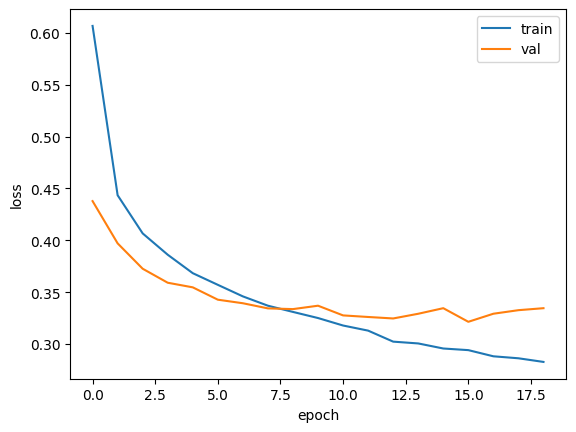

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [19]:
# 저장된 모델의 가중치를 로드
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

<All keys matched successfully>

In [20]:
model.eval()
with torch.no_grad():
    val_scaled = val_scaled.to(device)
    val_target = val_target.to(device)
    outputs = model(val_scaled)
    loss = criterion(outputs, val_target)
    predicts = torch.argmax(outputs, 1)
    corrects = (predicts == val_target).sum().item()

accuracy = corrects / len(val_target)
print(f"검증세트 정확도:{accuracy:.4f}, 손실값:{loss.item():.4f}")

검증세트 정확도:0.8878, 손실값:0.3214
